In [1]:
from pandas import read_csv, DataFrame
import numpy as np
from sklearn import naive_bayes, cross_validation, metrics, metrics, preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import random
import re
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")
import string
from matplotlib import pyplot as plt
%pylab inline
import pandas as pd
import textmining
import lda



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [6]:
cd C:\\Users\\8410106\\Documents\\STFeedback

C:\Users\8410106\Documents\STFeedback


In [79]:
train_data = read_csv('STFeedbackTrainingData.csv') # this is the pre-labelled training dataset

In [80]:
test_data = read_csv('Santiago Feedback_Master.csv') # this is my Santiago feedback sample

In [81]:
# lets give the NPS data some better column names *****8 THIS WILL CHANGE WHEN YOU TRAIN THE FEEDBACK ON ITSELF
#train_data.columns = ['Channel', 'time', 'brand', 'NPSGroup', 'NPS_Score', 'comments', 'Other1','Other2']

In [84]:
L = len(train_data)
print "You have a total of %r rows in your training data set" % L

L2 = len(test_data)
print "You have a total of %r rows in your test (feedback) data set" % L2

You have a total of 4254 rows in your training data set
You have a total of 16788 rows in your test (feedback) data set


In [122]:
#Let remove important words out of the stopword list
operators = set(('not'))
stop = set(cachedStopWords) - operators

In [123]:
# lets do some spring cleaning - take out stopwords and remove punctuation 
def CleaningText(x):
    if isinstance(x, basestring):
        x = re.sub('[^\x00-\x7F]+',' ', x)
        x = x.lower()
        x = ' '.join([word for word in x.split() if word not in stop])
        table = string.maketrans("","")
        x = x.translate(table, string.punctuation)
        x = x.strip()
        if x == "":
            x = "null"
        else: x = x
        
        return x
    else:
        return "."

In [124]:
def roundit (x):
    return round(x)

In [125]:
# Clean the data
test_data['CleanComments'] = test_data['FEDBCK_TX'].apply(CleaningText)
train_data['CleanComments'] = train_data['Comments'].apply(CleaningText)

In [126]:
#Build the sparce matrix for the Bayes model
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data.CleanComments)
X_test = vectorizer.transform(test_data.CleanComments) #need some help understanding this

In [127]:
model = naive_bayes.MultinomialNB().fit(X_train, list(train_data.Sentiment))

[ 0.89985896  0.89915374  0.89915374]
0.88446666115


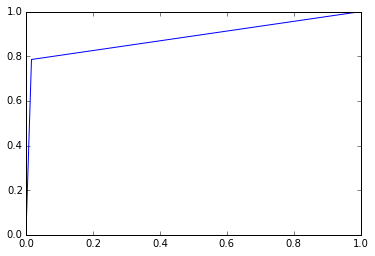

In [128]:
#Lets cross validate the test data to ensure it is predicting properly
print cross_validation.cross_val_score(naive_bayes.MultinomialNB(), X_train, train_data.Sentiment)
fpr, tpr, threshholds = metrics.roc_curve(train_data.Sentiment, model.predict (X_train), pos_label=1)
print metrics.auc(fpr, tpr)
plt.plot(fpr, tpr)

In [129]:
predictions = model.predict_proba(X_test)[:,1]
#submission = DataFrame({'index': test_data.index, 'NPSGroup': predictions })
#submission.to_csv('submission1.csv', index=False)

In [130]:
# now lets apply the model to the feedback data and add the output as an extra column

pred = DataFrame(predictions)
pred.columns = ['prediction']
pred['RoundedPredictions'] = pred['prediction'].apply(roundit)
roundedPredictions = pred.RoundedPredictions
test_data['ModelOutput'] = roundedPredictions

In [131]:
#Lets have a look at the output to test how the model did
test_data.to_csv('ModelOutputWithPredictions.csv', index=False)

In [132]:
#Ok here is where you look at the output and make any manual tweeks to the predictions

In [133]:
#Here it gets reloaded incase you have made any changes
TotalWithPredictions = pd.DataFrame(read_csv('ModelOutputWithPredictions.csv'))

In [134]:
#Isolate just the detractors to go into the LDA
negative_comments = TotalWithPredictions[TotalWithPredictions.ModelOutput == 0]

In [135]:
#Reset index so it doesnt have missing values
negative_comments = negative_comments.reset_index()

In [136]:
#Lets build the term document matrix
tdm = textmining.TermDocumentMatrix()

In [137]:
n = len(negative_comments)# tells you number of rows you need to loop through

In [138]:
comments = negative_comments['CleanComments']

In [139]:
counter = 0
for i in range (n):
    counter = counter + 1
    if i in comments:
        tdm.add_doc(comments[i])
        
        
    

In [140]:
#comments.to_csv('negatives.csv', index=False)

In [141]:
counter

15174

In [142]:
#Create the variables needed for the LDA model
temp = list(tdm.rows(cutoff=1))
vocab =tuple(temp[0]) #this is just the top row from the matrix... so all the vocab
X = np.array(temp[1:]) # this is all the rest... i.e all the zeros and ones from the matrix

MemoryError: 

In [137]:
#lets look at the shape of our TDM
print("type(X): {}".format(type(X)))
print("shape: {}".format(X.shape))
print("X:\n\n", X , "\n")


type(X): <type 'numpy.ndarray'>
shape: (995, 2527)
('X:\n\n', array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), '\n')


In [138]:
#Create and then fit the model
model = lda.LDA(n_topics=12, n_iter=500, random_state=1)
model.fit(X)


<lda.lda.LDA instance at 0x14B0C030>

In [139]:
topic_word = model.topic_word_
print("type(topic_word): {}".format(type(topic_word)))
print("shape: {}".format(topic_word.shape))


type(topic_word): <type 'numpy.ndarray'>
shape: (12, 2527)


In [140]:
n = 15
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n+1):-1]
    print('*Topic {}\n- {}'.format(i, ' '.join(topic_words)))


*Topic 0
- please pages internet statement error banking help make bank new contact account payment list us
*Topic 1
- new account site would design get page need use takes nice products services etc want
*Topic 2
- card credit account date statements also transactions doesnt balance cant one statement find view show
*Topic 3
- old back new one much please layout it previous version things system read like less
*Topic 4
- see old like scroll transactions would accounts really new much dont format easier previous change
*Topic 5
- banking new internet online like use dont website change time used great really every better
*Topic 6
- screen information page account side offers text right read large space statement left section accounts
*Topic 7
- much direct page more debits layout used go look like before order actions worse button
*Topic 8
- log button out find cant see cannot logout click still accounts disappears icon site screen
*Topic 9
- see layout one new first accounts find page

In [141]:
doc_topic = model.doc_topic_
print("type(doc_topic): {}".format(type(doc_topic)))
print("shape: {}".format(doc_topic.shape))

type(doc_topic): <type 'numpy.ndarray'>
shape: (995, 12)


In [145]:
# Lets apply the topics to the original documents
theTopics = doc_topic.argmax()
Output = pd.DataFrame(comments)
Output['Topic'] = Output.apply(lambda x: doc_topic[x.name].argmax(), axis=1)

In [151]:
#Lets output
negative_comments['Topic'] = Output['Topic']
negative_comments.to_csv('STFeedbackModelOutput.csv', index=False)

In [70]:
# lets check the topic-word distributions

f, ax= plt.subplots(9, 1, figsize=(8, 16), sharex=True)
for i, k in enumerate([0, 1, 2, 3, 4, 5, 6, 7]):
    ax[i].stem(topic_word[k,:], linefmt='b-',
               markerfmt='bo', basefmt='w-')
    ax[i].set_xlim(-50,600)
    ax[i].set_ylim(0, 0.10)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("topic {}".format(k))

ax[2].set_xlabel("word")

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

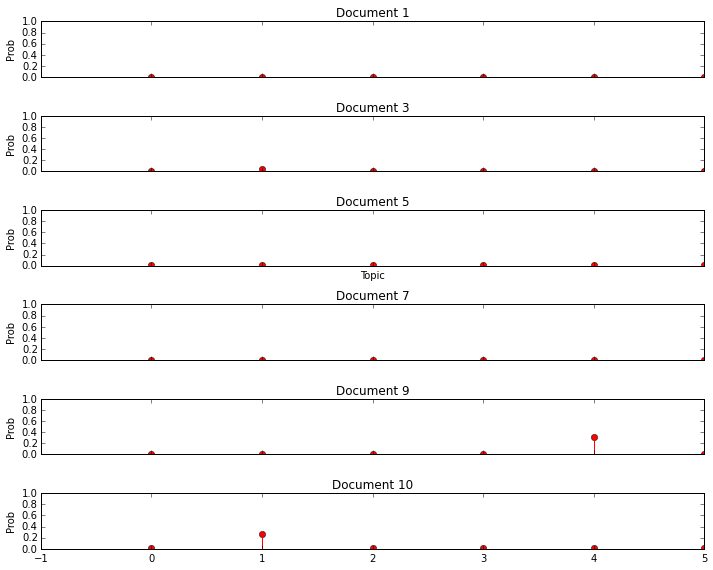

In [69]:
# lets look at the topic distribution for a few document
f, ax= plt.subplots(6, 1, figsize=(10, 8), sharex=True) # 8, 6 is the plot size
for i, k in enumerate([1, 3, 5, 7, 9, 10]):
    ax[i].stem(doc_topic[k,:], linefmt='r-',
               markerfmt='ro', basefmt='w-')
    ax[i].set_xlim(-1, 5)
    ax[i].set_ylim(0, 1)
    ax[i].set_ylabel("Prob")
    ax[i].set_title("Document {}".format(k))

ax[2].set_xlabel("Topic")

plt.tight_layout()
plt.show()
